In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torchvision.models as models 
import optuna
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import optuna
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
base_dir = "/kaggle/input/oral-diseases"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")
batch_size = 32

In [4]:
import os

base_dir = "/kaggle/input/oral-diseases"
image_ext = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")

def scan_recursive(folder_path):
    subfolder_list = []
    image_count = 0
    
    for root, dirs, files in os.walk(folder_path):
        # Add subfolders
        for d in dirs:
            subfolder_list.append(os.path.join(root, d))
        
        # Count image files
        for f in files:
            if f.lower().endswith(image_ext):
                image_count += 1

    return subfolder_list, image_count


total_dataset_images = 0
total_dataset_subfolders = 0

print("\n📊 FULL DATASET STRUCTURE\n")

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    # Scan entire class folder
    subfolders, image_count = scan_recursive(class_path)

    print(f"\n📁 CLASS: {class_name}")
    print(f"   📂 Total Subfolders: {len(subfolders)}")
    print(f"   🖼️ Total Images: {image_count}")

    if len(subfolders) > 0:
        print("   🔽 Subfolder List:")
        for sf in subfolders:
            print("      -", sf.replace(base_dir + "/", ""))  # cleaner printing
    else:
        print("   ✔ No subfolders (clean)")

    # Add to global totals
    total_dataset_images += image_count
    total_dataset_subfolders += len(subfolders)

print("\n" + "="*70)
print("📌 FINAL DATASET SUMMARY")
print(f"📂 Total subfolders in dataset: {total_dataset_subfolders}")
print(f"🖼️ Total images in dataset: {total_dataset_images}")
print("="*70)



📊 FULL DATASET STRUCTURE


📁 CLASS: Data caries
   📂 Total Subfolders: 5
   🖼️ Total Images: 2601
   🔽 Subfolder List:
      - Data caries/Data caries
      - Data caries/Data caries/caries orignal data set
      - Data caries/Data caries/caries augmented data set
      - Data caries/Data caries/caries orignal data set/done
      - Data caries/Data caries/caries augmented data set/preview

📁 CLASS: Mouth Ulcer
   📂 Total Subfolders: 5
   🖼️ Total Images: 2806
   🔽 Subfolder List:
      - Mouth Ulcer/Mouth Ulcer
      - Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet
      - Mouth Ulcer/Mouth Ulcer/ulcer original dataset
      - Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview
      - Mouth Ulcer/Mouth Ulcer/ulcer original dataset/ulcer original dataset

📁 CLASS: Tooth Discoloration
   📂 Total Subfolders: 5
   🖼️ Total Images: 2017
   🔽 Subfolder List:
      - Tooth Discoloration/Tooth Discoloration 
      - Tooth Discoloration/Tooth Discoloration /Tooth_discoloratio

In [5]:
import os
import shutil

# Original dataset
base_dir = "/kaggle/input/oral-diseases"

# New clean flattened dataset
clean_dir = "/kaggle/working/clean-dataset"
os.makedirs(clean_dir, exist_ok=True)

# List of folders/classes to exclude (YOLO dataset)
exclude_folders = [
    "Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset"
]

# Valid image extensions
image_ext = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")

print("🚀 Starting dataset cleaning + flattening...\n")

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

    # Skip non-folders
    if not os.path.isdir(class_path):
        continue

    # Skip YOLO dataset
    if class_name in exclude_folders:
        print(f"❌ Skipping YOLO dataset folder: {class_name}")
        continue

    # Create output class folder
    output_class_dir = os.path.join(clean_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    print(f"📁 Processing class: {class_name}")

    # Walk recursively through all nested folders
    for root, dirs, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(image_ext):
                src = os.path.join(root, file)

                # Prevent filename collisions
                dst = os.path.join(output_class_dir, file)
                if os.path.exists(dst):
                    filename, ext = os.path.splitext(file)
                    dst = os.path.join(output_class_dir, f"{filename}_dup{ext}")

                shutil.copy(src, dst)

    # Count final images
    count = len([f for f in os.listdir(output_class_dir) 
                 if f.lower().endswith(image_ext)])
    print(f"   ✔ Copied {count} images")

print("\n🎉 DONE! Clean dataset created at: /kaggle/working/clean-dataset")


🚀 Starting dataset cleaning + flattening...

📁 Processing class: Data caries
   ✔ Copied 2601 images
📁 Processing class: Mouth Ulcer
   ✔ Copied 2806 images
📁 Processing class: Tooth Discoloration
   ✔ Copied 2017 images
📁 Processing class: hypodontia
   ✔ Copied 1251 images
❌ Skipping YOLO dataset folder: Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset
📁 Processing class: Gingivitis
   ✔ Copied 2349 images
📁 Processing class: Calculus
   ✔ Copied 1296 images

🎉 DONE! Clean dataset created at: /kaggle/working/clean-dataset


In [6]:
import os

clean_dir = "/kaggle/working/clean-dataset"
image_ext = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")

print("📊 VERIFYING CLEAN DATASET...\n")

total_images = 0

for class_name in os.listdir(clean_dir):
    class_path = os.path.join(clean_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    # Count images
    image_count = len([
        f for f in os.listdir(class_path)
        if f.lower().endswith(image_ext)
    ])

    # Count subfolders (should be 0 if flattened correctly)
    subfolder_count = len([
        d for d in os.listdir(class_path)
        if os.path.isdir(os.path.join(class_path, d))
    ])

    total_images += image_count

    print(f"📁 Class: {class_name}")
    print(f"   🖼️ Images: {image_count}")
    print(f"   📂 Subfolders: {subfolder_count}")
    if subfolder_count > 0:
        print("   ⚠️ WARNING: Some nested folders still exist!")
    print("-" * 50)

print(f"\n📌 FINAL TOTAL IMAGES IN DATASET: {total_images}")
print("=" * 50)


📊 VERIFYING CLEAN DATASET...

📁 Class: hypodontia
   🖼️ Images: 1251
   📂 Subfolders: 0
--------------------------------------------------
📁 Class: Tooth Discoloration
   🖼️ Images: 2017
   📂 Subfolders: 0
--------------------------------------------------
📁 Class: Gingivitis
   🖼️ Images: 2349
   📂 Subfolders: 0
--------------------------------------------------
📁 Class: Data caries
   🖼️ Images: 2601
   📂 Subfolders: 0
--------------------------------------------------
📁 Class: Mouth Ulcer
   🖼️ Images: 2806
   📂 Subfolders: 0
--------------------------------------------------
📁 Class: Calculus
   🖼️ Images: 1296
   📂 Subfolders: 0
--------------------------------------------------

📌 FINAL TOTAL IMAGES IN DATASET: 12320


In [7]:
base_dir = "/kaggle/working/clean-dataset"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")
batch_size = 32

target_size= (224 , 224)
training_scale = 256
image_transforms = {
    "train": transforms.Compose([
    # Resize the smaller side of the image to the training scale
    transforms.Resize(training_scale),    
    transforms.RandomCrop(224),    
    transforms.RandomHorizontalFlip(),    
    transforms.ToTensor(),    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [8]:
full_dataset = datasets.ImageFolder(base_dir, transform=image_transforms["train"])

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(
    full_dataset, [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print("Datasets created successfully!")
print(f"Classes: {full_dataset.classes}")
print(f"Class to index mapping: {full_dataset.class_to_idx}")
print(f"Total images: {total_size}")
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully!")

Datasets created successfully!
Classes: ['Calculus', 'Data caries', 'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'hypodontia']
Class to index mapping: {'Calculus': 0, 'Data caries': 1, 'Gingivitis': 2, 'Mouth Ulcer': 3, 'Tooth Discoloration': 4, 'hypodontia': 5}
Total images: 12320
Train size: 8624
Validation size: 1848
Test size: 1848
Data loaders created successfully!


In [9]:
import torch
import torch.nn as nn
#   Bottleneck Block
class Bottleneck(nn.Module):
    expansion = 4  # output channels multiplier

    def __init__(self, in_channels, mid_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, mid_channels * self.expansion, 
                               kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(mid_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

#   ResNet-50 Network
class ResNet50(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet50, self).__init__()

        self.in_channels = 64

        # Initial layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # ResNet-50 layers: (3, 4, 6, 3) bottleneck blocks
        self.layer1 = self._make_layer(64,  3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        # Fully connected head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, mid_channels, blocks, stride=1):
        downsample = None
        
        # If input and output channels differ → use 1x1 conv downsample
        if stride != 1 or self.in_channels != mid_channels * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels,
                          mid_channels * Bottleneck.expansion,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(mid_channels * Bottleneck.expansion)
            )

        layers = []
        layers.append(Bottleneck(self.in_channels, mid_channels, stride, downsample))
        self.in_channels = mid_channels * Bottleneck.expansion

        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_channels, mid_channels))

        return nn.Sequential(*layers)

    #   Forward Pass
    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)   # 3 blocks
        x = self.layer2(x)   # 4 blocks
        x = self.layer3(x)   # 6 blocks
        x = self.layer4(x)   # 3 blocks

        x = self.avgpool(x)  # Bx2048x1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [10]:
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.tolist())


import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

Class weights: tensor([1.5988, 0.7937, 0.8711, 0.7322, 1.0143, 1.6259], device='cuda:0')


In [11]:
num_epochs = 20
learning_rate = 3e-4
weight_decay = 1e-4

In [12]:
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Helper: Confusion Matrix Plot
# --------------------------
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# --------------------------
# Helper: Evaluate Model
# --------------------------
def evaluate_model(model, data_loader, device, class_names, train_losses, val_losses, train_accuracies, val_accuracies):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\n✅ Evaluation Results")
    print(f"Accuracy: {acc:.4f} | Weighted F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


    # ✅ ADD THE PLOTTING CODE HERE (this is missing!)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', linewidth=2)
    plt.plot(val_accuracies, label='Val Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    

    plot_confusion_matrix(all_labels, all_preds, classes=class_names)

In [13]:
model = ResNet50(num_classes=6).to(device)
##criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.01, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=20, device='cuda', class_names=None):

    best_val_loss = float('inf')

    train_losses = []
    val_losses = []
    train_accuracies = [] 
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print("="*50)
        print(f"Epoch [{epoch}/{num_epochs}]")
        print("-"*50)
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        train_losses.append(epoch_loss)
        
        epoch_acc = running_corrects / total
        train_accuracies.append(epoch_acc)
        
        print(f"💡 Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")

        # --------------------------
        # Validation
        # --------------------------
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_loss / val_total
        val_losses.append(val_epoch_loss)
        
        val_epoch_acc = val_corrects / val_total
        val_accuracies.append(val_epoch_acc)
        print(f"💡 Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")

        # Scheduler step
        scheduler.step(val_epoch_loss)

        # Save best model
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), "best_resnet50.pth")
            print("💾 Saved best model!")

    print("="*50)
    print("\n🎯 Training Complete! Evaluating on Validation Set...")
    # Evaluate and show confusion matrix and classification report
    evaluate_model(model, val_loader, device, class_names, train_losses, val_losses, train_accuracies, val_accuracies)
    

Epoch [1/20]
--------------------------------------------------


💡 Train Loss: 1.3281 | Train Acc: 0.4682


💡 Val Loss: 1.5301 | Val Acc: 0.5541
💾 Saved best model!
Epoch [2/20]
--------------------------------------------------


💡 Train Loss: 1.0503 | Train Acc: 0.5780


💡 Val Loss: 0.9326 | Val Acc: 0.5958
💾 Saved best model!
Epoch [3/20]
--------------------------------------------------


💡 Train Loss: 0.9355 | Train Acc: 0.6240


💡 Val Loss: 1.1677 | Val Acc: 0.5254
Epoch [4/20]
--------------------------------------------------


💡 Train Loss: 0.8539 | Train Acc: 0.6546


💡 Val Loss: 1.0428 | Val Acc: 0.6304
Epoch [5/20]
--------------------------------------------------


💡 Train Loss: 0.7921 | Train Acc: 0.6837


💡 Val Loss: 0.7578 | Val Acc: 0.6748
💾 Saved best model!
Epoch [6/20]
--------------------------------------------------


💡 Train Loss: 0.7559 | Train Acc: 0.7034


💡 Val Loss: 0.8764 | Val Acc: 0.6672
Epoch [7/20]
--------------------------------------------------


💡 Train Loss: 0.7130 | Train Acc: 0.7149


💡 Val Loss: 0.7666 | Val Acc: 0.7067
Epoch [8/20]
--------------------------------------------------


💡 Train Loss: 0.6794 | Train Acc: 0.7370


💡 Val Loss: 0.6522 | Val Acc: 0.7419
💾 Saved best model!
Epoch [9/20]
--------------------------------------------------


💡 Train Loss: 0.6633 | Train Acc: 0.7365


💡 Val Loss: 0.7027 | Val Acc: 0.7462
Epoch [10/20]
--------------------------------------------------


💡 Train Loss: 0.6244 | Train Acc: 0.7557


💡 Val Loss: 0.7725 | Val Acc: 0.7181
Epoch [11/20]
--------------------------------------------------


💡 Train Loss: 0.6131 | Train Acc: 0.7549


💡 Val Loss: 0.7630 | Val Acc: 0.7181
Epoch [12/20]
--------------------------------------------------


💡 Train Loss: 0.4805 | Train Acc: 0.8144


💡 Val Loss: 0.5296 | Val Acc: 0.7781
💾 Saved best model!
Epoch [13/20]
--------------------------------------------------


💡 Train Loss: 0.4659 | Train Acc: 0.8174


💡 Val Loss: 0.5597 | Val Acc: 0.7792
Epoch [14/20]
--------------------------------------------------


💡 Train Loss: 0.4371 | Train Acc: 0.8321


💡 Val Loss: 0.5251 | Val Acc: 0.7814
💾 Saved best model!
Epoch [15/20]
--------------------------------------------------


💡 Train Loss: 0.4237 | Train Acc: 0.8359


💡 Val Loss: 0.5114 | Val Acc: 0.7933
💾 Saved best model!
Epoch [16/20]
--------------------------------------------------


💡 Train Loss: 0.4224 | Train Acc: 0.8349


💡 Val Loss: 0.5657 | Val Acc: 0.8019
Epoch [17/20]
--------------------------------------------------


💡 Train Loss: 0.4007 | Train Acc: 0.8408


💡 Val Loss: 0.4564 | Val Acc: 0.8225
💾 Saved best model!
Epoch [18/20]
--------------------------------------------------


💡 Train Loss: 0.4044 | Train Acc: 0.8467


💡 Val Loss: 0.4313 | Val Acc: 0.8393
💾 Saved best model!
Epoch [19/20]
--------------------------------------------------


💡 Train Loss: 0.3886 | Train Acc: 0.8527


💡 Val Loss: 0.4121 | Val Acc: 0.8447
💾 Saved best model!
Epoch [20/20]
--------------------------------------------------


💡 Train Loss: 0.3706 | Train Acc: 0.8561


💡 Val Loss: 0.5170 | Val Acc: 0.8295

🎯 Training Complete! Evaluating on Validation Set...

✅ Evaluation Results
Accuracy: 0.8339 | Weighted F1 Score: 0.8246

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.70      0.33      0.45       198
        Data caries       0.81      0.95      0.87       408
         Gingivitis       0.70      0.88      0.78       360
        Mouth Ulcer       0.95      0.90      0.93       411
Tooth Discoloration       0.92      0.87      0.89       285
         hypodontia       0.92      0.84      0.88       186

           accuracy                           0.83      1848
          macro avg       0.83      0.79      0.80      1848
       weighted avg       0.84      0.83      0.82      1848



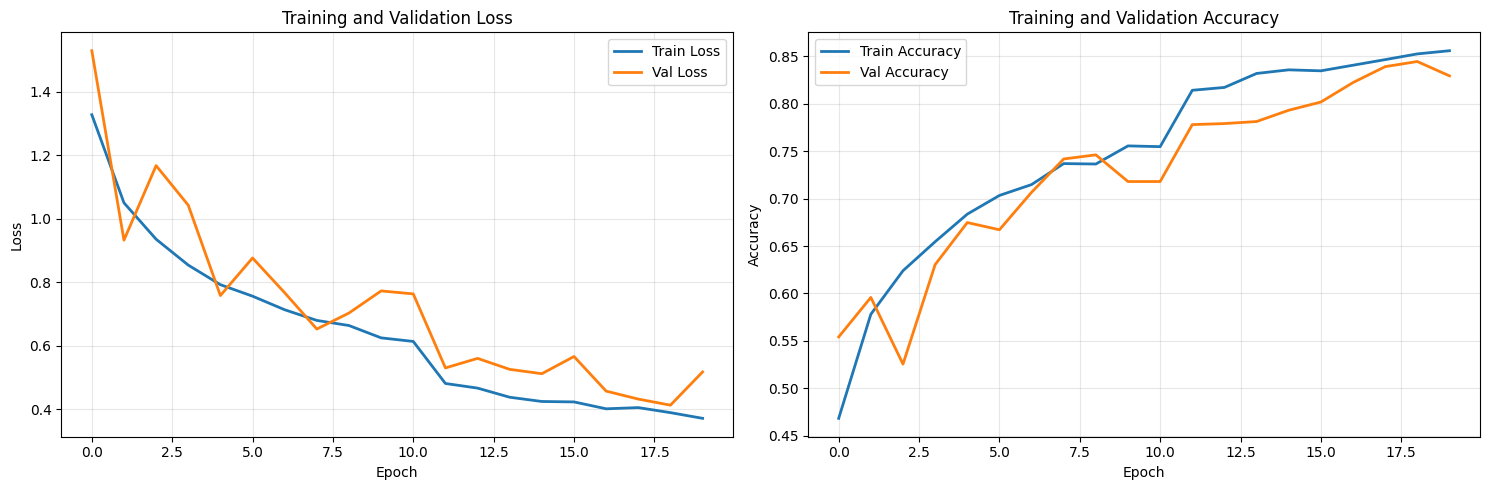

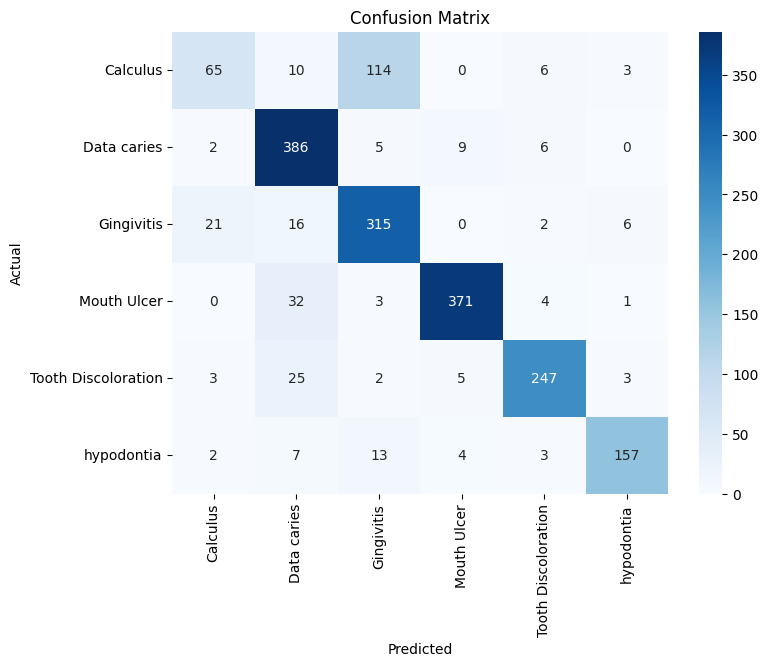

In [15]:
class_names = ['Calculus', 'Data caries', 
               'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'hypodontia']

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    class_names=class_names
)
